In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('archive\\accepted_2007_to_2018Q4.csv')
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(2260701, 151)

In [8]:
df.duplicated().sum()

0

In [9]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [10]:
df = df[(df['loan_status'] == 'Fully Paid')| (df['loan_status'] == 'Charged Off')]

In [11]:
df.shape

(1345310, 151)

In [12]:
def check_missed_values(df):
    df_null_percentage = df.isnull().sum() / df.shape[0] * 100
    df_null_percentage = df_null_percentage.sort_values(ascending= False).reset_index()
    df_null_percentage.columns = ['Feature', 'Percentage']
    return df_null_percentage

null_df = check_missed_values(df)

<AxesSubplot:xlabel='Percentage', ylabel='Feature'>

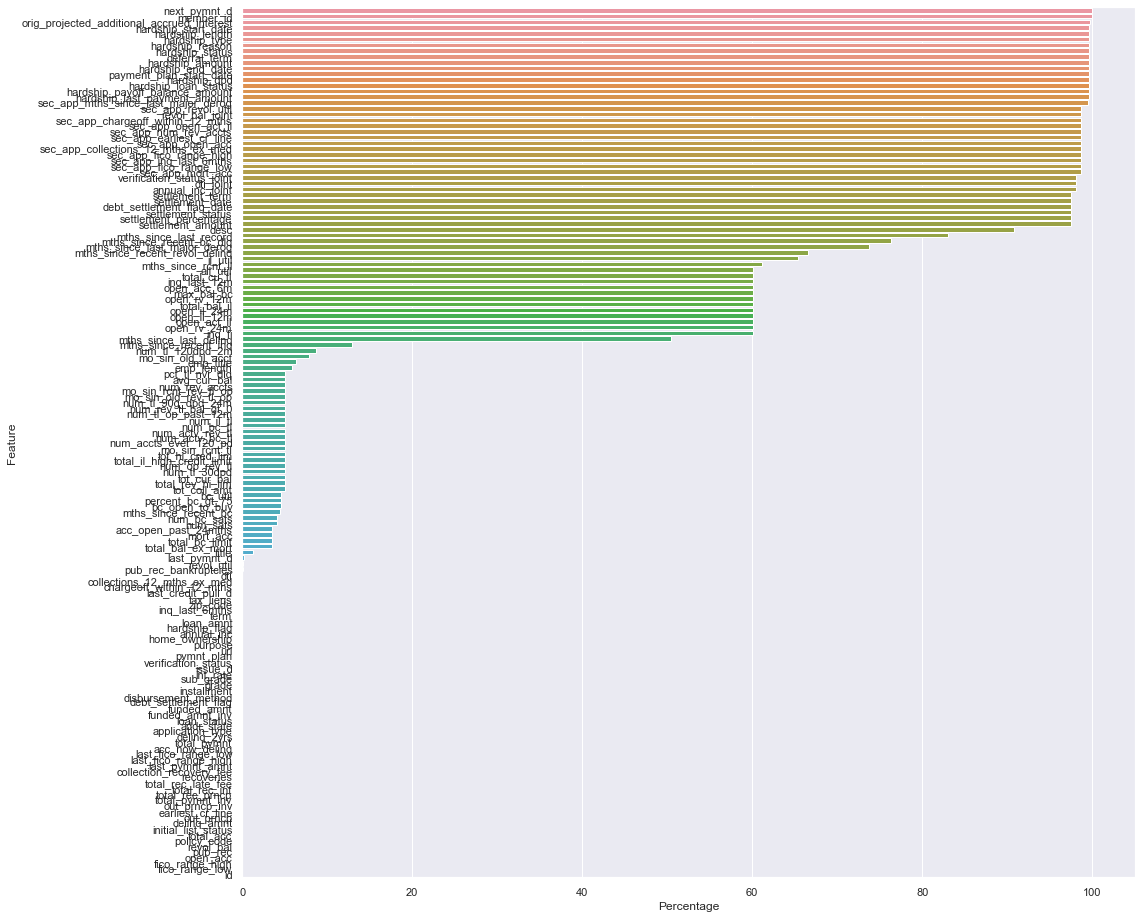

In [13]:
plt.figure(figsize=(16,16))
sns.barplot(x=  null_df['Percentage'] , y= null_df['Feature'] )

## Drop features missing more than 30% data

In [14]:
keep_col = null_df[null_df['Percentage'] < 30]['Feature']
keep_col

58     mths_since_recent_inq
59          num_tl_120dpd_2m
60        mo_sin_old_il_acct
61                 emp_title
62                emp_length
               ...          
146                  pub_rec
147                 open_acc
148          fico_range_high
149           fico_range_low
150                       id
Name: Feature, Length: 93, dtype: object

In [15]:
len(keep_col)

93

In [16]:
## There are to many features and some are not necessary for investors so Let's trim some features

In [17]:
keep_col = [
    # thông tin khoản vay
    'id','loan_status', 'loan_amnt', 'term', 'int_rate','installment','grade','sub_grade', 'issue_d', 'purpose', 'title', 'application_type', 'initial_list_status',

    #thông tin người vay
    'emp_title','emp_length', 'zip_code', 'addr_state',

    #thông tin lịch sử tài chính của người vay
    'home_ownership', 'annual_inc', 'verification_status', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'mort_acc', 'pub_rec_bankruptcies' , 'fico_range_high', 'fico_range_low' ]

In [18]:
df = df[keep_col]
df.shape

(1345310, 31)

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df = reduce_mem_usage(df)

Mem. usage decreased to 225.81 Mb (31.2% reduction)


In [20]:
df.to_csv('Trim_feature_Loan_2007_2018Q4.csv',index= False)